In [65]:
#Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [66]:
#Прочитаем датасет

diabetes = pd.read_csv('data/diabetes_data.csv')
display(diabetes.head())
display(diabetes.shape)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female


(778, 10)

Число дубликатов: 10
Результирующее число записей: 768

Признак Gender: 100.0% одинаковых значений

Оставшееся количество признаков: 9
Результирующая доля пропущенных значений: 0.49


'Столбцы с пропусками:'

Insulin          48.697917
SkinThickness    29.557292
BloodPressure     4.557292
BMI               1.432292
Glucose           0.651042
dtype: float64

Осталось столбцов: 8
Осталось строк: 761
Среднее значение SkinThickness: 29.1

Всего значений признака: 761
Число выбросов по методу Тьюки: 87
Число значений после применения метода Тьюки: 674


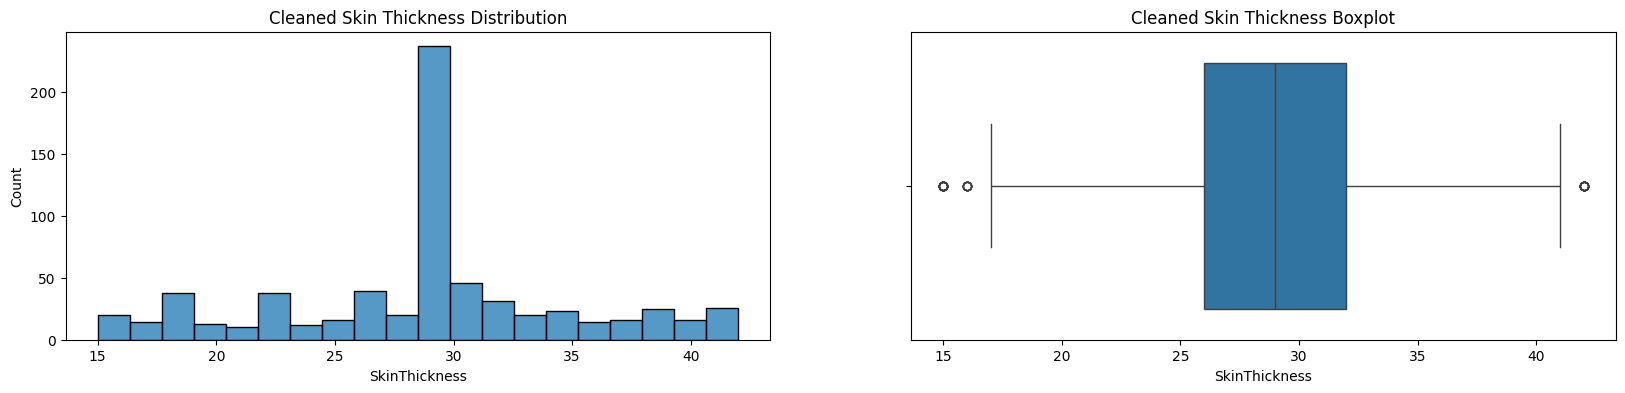

In [87]:
#Задание 8.1
#Поиск дубликатов

#Сделаю копию данных
diabetes_copy = diabetes.copy()
dupl_columns = list(diabetes.columns)
mask = diabetes.duplicated(subset=dupl_columns)
diabetes_duplicates = diabetes[mask]
print(f'Число дубликатов: {diabetes_duplicates.shape[0]}')

#Удаляем найденные дубликаты
diabetes_copy = diabetes.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {diabetes_copy.shape[0]}')

#Задание 8.2
#Ищем дубликаты
print('')
low_information_cols = []

for col in diabetes_copy.columns:
    top_freq = diabetes_copy[col].value_counts(normalize=True).max()
    nunique_ratio = diabetes_copy[col].nunique() / diabetes_copy[col].count()
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'Признак {col}: {round(100*top_freq, 2)}% одинаковых значений')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'Признак {col}: {round(100*nunique_ratio, 2)}% уникальных значений')

#Удаляем неиформативные признаки
diabetes_copy = diabetes_copy.drop(low_information_cols, axis=1)
print('')
print('Оставшееся количество признаков:', diabetes_copy.shape[1])

#Задание 8.3: заменяем нули на NaN-значения
#Создадим список и копию датасета из столбов для фильтрации:
list_zero_to_nans = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
def zero_to_nan(x):
    return np.nan if x==0 else x
for col in diabetes_copy.columns:
    if col in list_zero_to_nans:
        diabetes_copy[col] = diabetes_copy[col].apply(zero_to_nan)
print('Результирующая доля пропущенных значений:', \
    round(diabetes_copy['Insulin'].isnull().mean(), 2)) #0.49

#Задание 8.4
cols_null_percent = diabetes_copy.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display('Столбцы с пропусками:', cols_with_null)
thresh = diabetes_copy.shape[0] * 0.7
diabetes_copy = diabetes_copy.dropna(thresh=thresh, axis=1)
print('Осталось столбцов:', diabetes_copy.shape[1]) #8

#Задание 8.5
diabetes_copy = diabetes_copy.dropna\
    (thresh=diabetes_copy.shape[1]-2, axis=0)
print('Осталось строк:', diabetes_copy.shape[0]) #761

#Задание 8.6
#Создаём словарь значений
values = {
    'BMI': diabetes_copy['BMI'].median(),
    'SkinThickness': diabetes_copy['SkinThickness'].median(),
    'BloodPressure': diabetes_copy['BloodPressure'].median(),
    'Glucose': diabetes_copy['Glucose'].median()
}
#Заполняем записи константами из словаря values
diabetes_copy = diabetes_copy.fillna(values)
print('Среднее значение SkinThickness:', \
    round(diabetes_copy['SkinThickness'].mean(), 1))

#Задание 8.7
print('')
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliners = data[(x < lower_bound)|(x > upper_bound)]
    cleaned = data[(x >= lower_bound)&(x <= upper_bound)]
    return outliners, cleaned

outliners, cleaned = outliers_iqr_mod(diabetes_copy, 'SkinThickness')
print('Всего значений признака:', diabetes_copy['SkinThickness'].shape[0])
print(f'Число выбросов по методу Тьюки: {outliners.shape[0]}')
print(f'Число значений после применения метода Тьюки: {cleaned.shape[0]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
histplot = sns.histplot(data=cleaned, x='SkinThickness', ax=axes[0]);
histplot.set_title('Cleaned Skin Thickness Distribution');
boxplot = sns.boxplot(data=cleaned, x='SkinThickness', ax=axes[1]);
boxplot.set_title('Cleaned Skin Thickness Boxplot');
#87

Число выбросов по методу z-отклонения: 4
Число оставшихся строк: 761


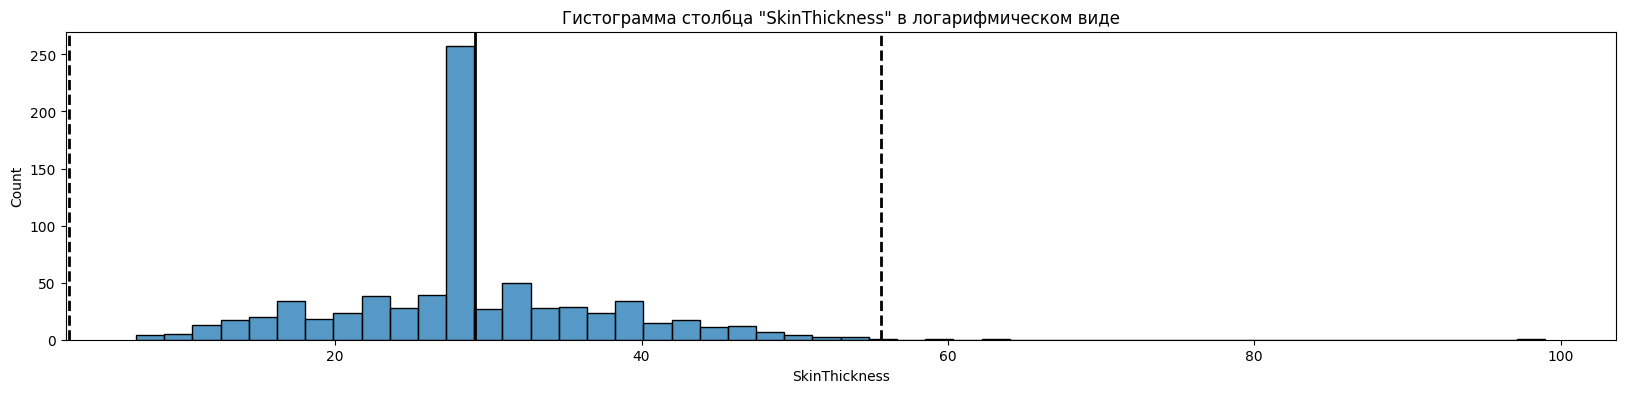

In [80]:
#Задание 8.8
def outliers_z_score_mod(data, feature, log_scale=False,
                         left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left*sigma
    upper_bound = mu + right*sigma
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(diabetes_copy, ['SkinThickness'])
print('Число выбросов по методу z-отклонения:', np.sum(outliers.count()))
print('Число оставшихся строк:', cleaned.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(20,4))
histplot = sns.histplot(diabetes_copy['SkinThickness'], bins=50, ax=ax)
histplot.axvline(diabetes_copy['SkinThickness'].mean(), color='k', lw=2)
histplot.axvline(diabetes_copy['SkinThickness'].mean()+ 3 * diabetes_copy['SkinThickness'].std(), color='k', lw=2, ls='--')
histplot.axvline(diabetes_copy['SkinThickness'].mean()- 3 * diabetes_copy['SkinThickness'].std(), color='k', lw=2, ls='--')
histplot.set_title('Гистограмма столбца "SkinThickness" в логарифмическом виде');
#4

In [88]:
outliers_pedigree, cleaned_pedigree = outliers_iqr_mod(diabetes_copy, 'DiabetesPedigreeFunction')
print('Всего значений признака:', diabetes_copy['SkinThickness'].shape[0])
print(f'Число выбросов по методу Тьюки: {outliers_pedigree.shape[0]}')
print(f'Число значений после применения метода Тьюки: {cleaned_pedigree.shape[0]}')
print('')
outliers_pedigree_log, cleaned_pedigree_log = outliers_iqr_mod(diabetes_copy, 'DiabetesPedigreeFunction', log_scale=True)
print('Всего значений признака:', diabetes_copy['DiabetesPedigreeFunction'].shape[0])
print(f'Число выбросов по методу Тьюки: {outliers_pedigree_log.shape[0]}')
print(f'Число значений после применения метода Тьюки: {cleaned_pedigree_log.shape[0]}')

print(f'Разница между нелогарифмированным столбцом и логарифмированным: \
{outliers_pedigree.shape[0]-outliers_pedigree_log.shape[0]}')

Всего значений признака: 761
Число выбросов по методу Тьюки: 29
Число значений после применения метода Тьюки: 732

Всего значений признака: 761
Число выбросов по методу Тьюки: 0
Число значений после применения метода Тьюки: 761
Разница между нелогарифмированным столбцом и логарифмированным: 29
